# Imports

## Libraries

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3090


In [3]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler,discard_random_labels, remove_duplicates_preserve_order
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import create_image_grid_from_routes, plot_single_image, visualize_static_orbits
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.propagation import jacobi_constant
from orbit_generation.experiment import get_experiment_data
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids

In [4]:
import numpy as np
import os

In [5]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

## Params

In [7]:
# Experiment 116 parameters (try 86)
params=  {
            "data_used": "EM_N_fix_1500",
            "families_to_discard": 30,
            "seq_len": 100,
            "feature_dim": 7,
            "epochs": 50,
            "val_split": 0.05,
            "batch_size": 32,
            "lr": 0.001,
            "model_name": "vae_conv5_legit",
            "latent_dim": 2,
            "max_iter_convergence": 20,
            "input_seq_len_convergence": 1,
            "samples_to_generate": 100,
            "distance_metric": "euclidean",
            "model_kwargs": {
                "dropout_rate": 0.2,
                "beta": 1
            }
}

In [8]:
experiment_folder = "../experiments/experiment_116"
images_folder = os.path.join(experiment_folder, 'images')
experiment_id = int(os.path.basename(experiment_folder).split('_')[1])

In [9]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
full_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_full_latent_space')
discarded_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_discarded_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
full_family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_full_family_centroids')
## Feature Spaces
features_plot_path = os.path.join(images_folder, f'exp{experiment_id}_features')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
full_histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_full_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(experiment_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


## Data

In [10]:
full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
full_data.shape

(45211, 7, 100)

Remove specific families from the training data

In [11]:
full_orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]

experiment_data = get_experiment_data(experiments_folder=experiments_folder, experiment_id=experiment_id)
discarded_family_ids = experiment_data.get('discarded_family_ids', {})  
discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), discarded_family_ids)
discarded_families = get_orbit_classes(discarded_family_ids)[0]
orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]

discarded_families

['S_L4_SP',
 'S_L1_V',
 'S_L1_HS',
 'S_R34',
 'S_L1_L',
 'S_L4_V',
 'S_R23',
 'S_L2_HN',
 'S_R43',
 'S_R32',
 'S_L1_A',
 'S_R21',
 'S_LPOE',
 'S_R13',
 'S_DPO',
 'S_R14',
 'S_L3_HS',
 'S_DS',
 'S_L2_L',
 'S_DRO',
 'S_L5_A',
 'S_L3_HN',
 'S_BS',
 'S_L3_L',
 'S_L5_V',
 'S_R41',
 'S_L4_A',
 'S_L2_HS',
 'S_LPOW',
 'S_BN']

Get Features

In [12]:
family_labels = get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

Scale

In [ ]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([11367, 7, 100])

## Model

In [14]:
model = get_model(params)
model.load_state_dict(torch.load(model_save_path, weights_only=True))

<All keys matched successfully>

# Dataset Latent Space

## Calculations

In [15]:
latent_means, latent_log_vars = model.encode(scaled_data)

latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


(11367, 4)

In [16]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

(11367, 2)

In [17]:
features.shape

(11367, 3)

In [18]:
# Scale full data
full_scaled_data = scaler.transform(torch.tensor(full_data, dtype=torch.float32))

# Encode full data
full_latent_means, full_latent_log_vars= model.encode(full_scaled_data)

full_latent_means = full_latent_means.detach().numpy()

# Calculate stdevs
full_latent_stdevs = torch.exp(0.5 * full_latent_log_vars)
full_latent_stdevs = full_latent_stdevs.detach().numpy()
full_latent_stdevs.shape

(45211, 2)

In [19]:
full_family_labels=get_orbit_classes(full_orbits_id_classes)[0]
family_labels_discarded_train = [label if label in discarded_families else 'training' for label in full_family_labels]
family_labels_discarded_train = np.array(family_labels_discarded_train)
family_labels_discarded_train.shape

(45211,)

In [20]:
full_features=full_orbit_df[feature_names].to_numpy()
full_features.shape

(45211, 3)

In [21]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(10, 2)

In [22]:
# Compute centroid labels
unique_classes = remove_duplicates_preserve_order(orbits_id_classes)
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

10

In [23]:
# Compute full data centroid
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([-2.964384e-02, -3.412331e-05], dtype=float32)

In [24]:
# Compute centroids
full_centroid_means = compute_centroids(full_latent_means, full_orbits_id_classes, method='mean')
full_centroid_log_vars = compute_centroids(full_latent_log_vars.detach().numpy(), full_orbits_id_classes, method='mean')
full_centroid_stdevs = compute_centroids(full_latent_stdevs, full_orbits_id_classes, method='mean')
full_centroid_stdevs.shape

(40, 2)

In [25]:
# Calculate full centroid labels
full_unique_classes = remove_duplicates_preserve_order(full_orbits_id_classes)
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

In [26]:
families_discarded_train = [label if label in discarded_families else 'training' for label in full_family_names]
families_discarded_train = np.array(families_discarded_train)
discarded_orbit_indices = [i for i in range(len(family_labels_discarded_train)) if family_labels_discarded_train[i] != 'training']
len(families_discarded_train)

40

## Training

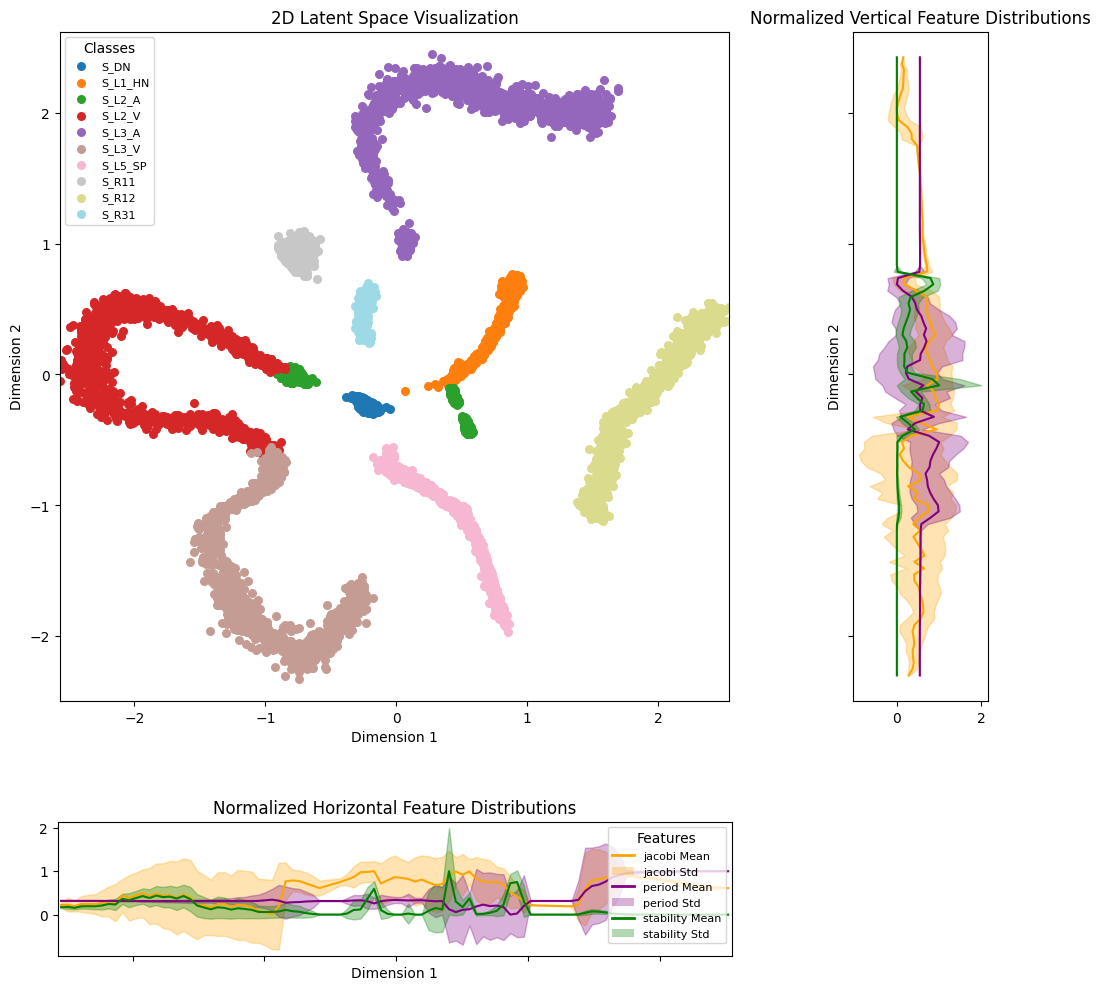

In [27]:
plot_2d_latent_space(latent_means, np.array(family_labels), features=features,
                        feature_names=feature_names,plot_std=True)

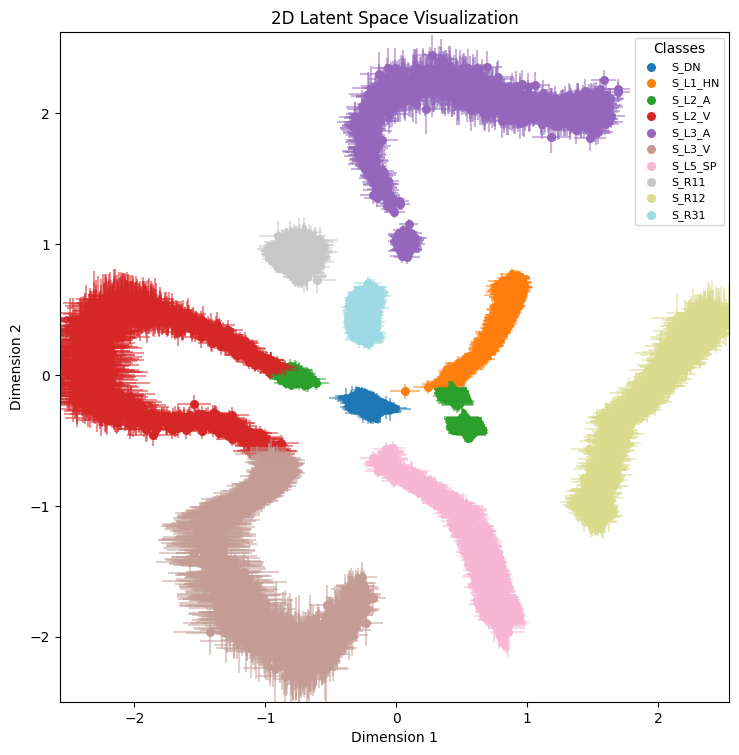

In [28]:
plot_2d_latent_space(latent_means, np.array(family_labels), latent_stdevs=latent_stdevs)

## Full Dataset

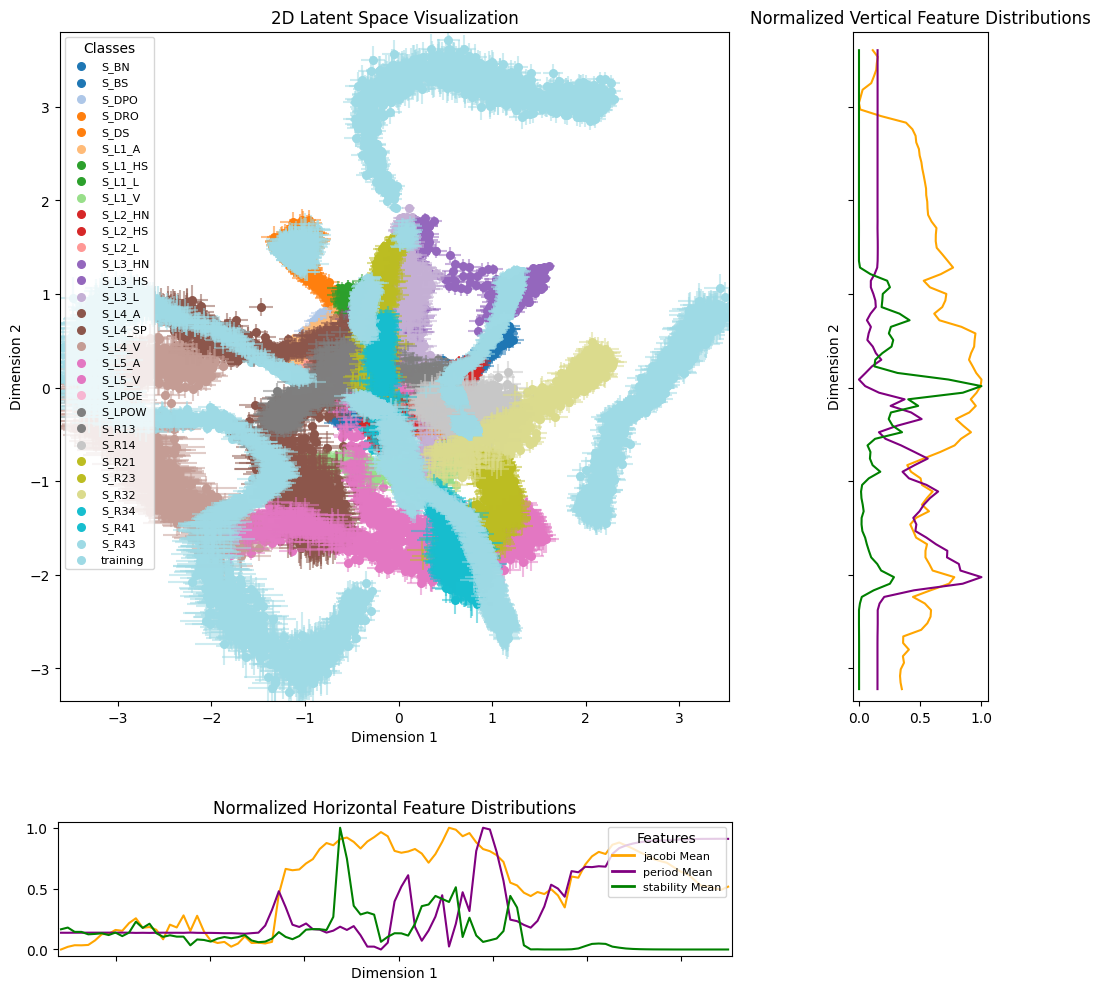

In [29]:
plot_2d_latent_space(full_latent_means, family_labels_discarded_train, features=full_features,
                     feature_names=feature_names, plot_std=False, latent_stdevs=full_latent_stdevs)

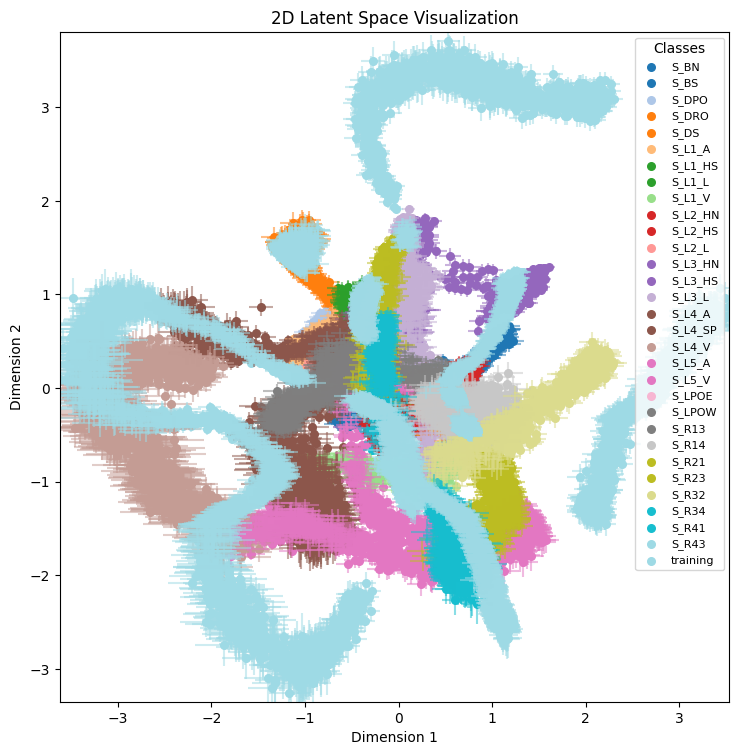

In [30]:
plot_2d_latent_space(full_latent_means, family_labels_discarded_train, latent_stdevs=full_latent_stdevs)

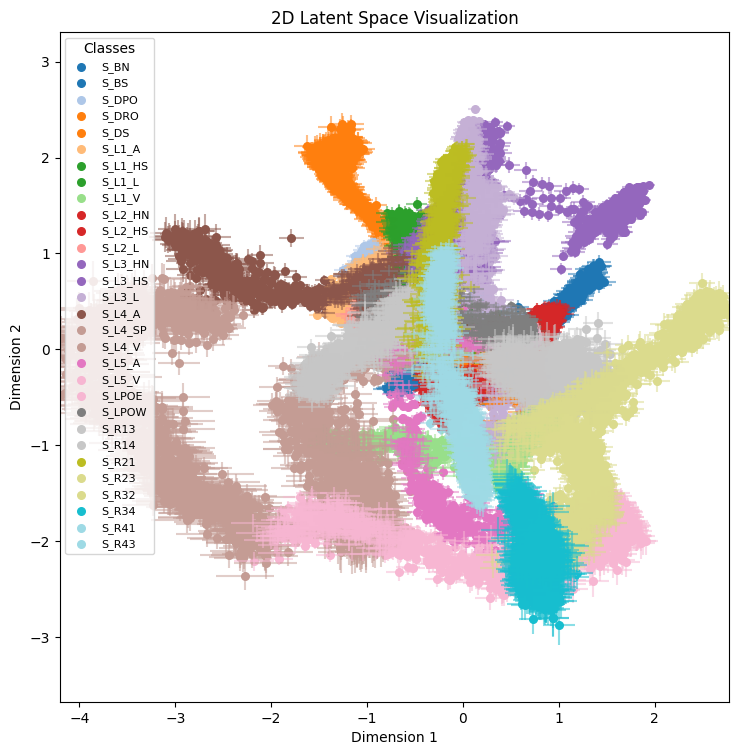

In [31]:
plot_2d_latent_space(full_latent_means[discarded_orbit_indices],
                        family_labels_discarded_train[discarded_orbit_indices],
                        save_path=discarded_latent_space_path,
                        features=full_features[discarded_orbit_indices],
                        latent_stdevs=full_latent_stdevs[discarded_orbit_indices])

## Training Centroids

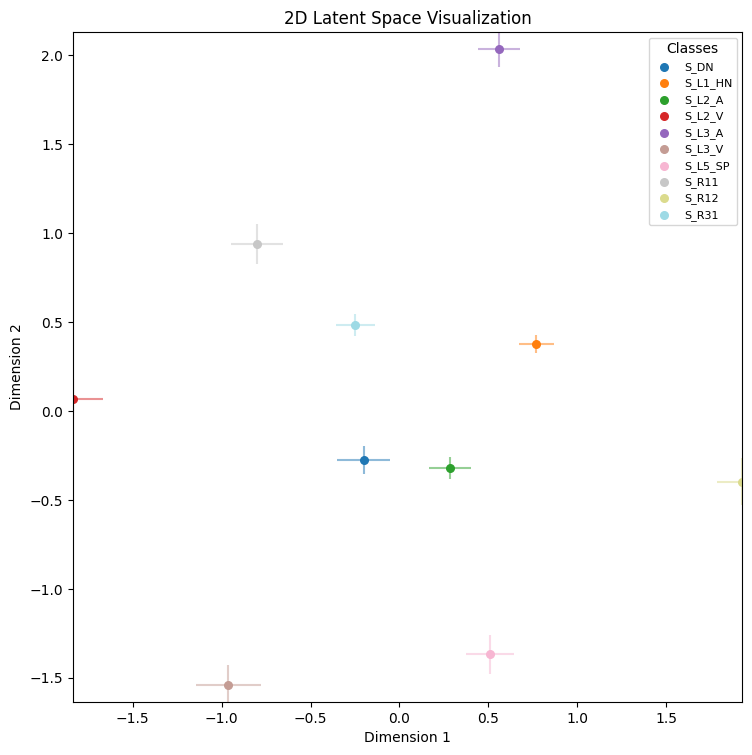

In [32]:
plot_2d_latent_space(centroid_means, np.array(family_names), latent_stdevs=centroid_stdevs)

## Full Centroids

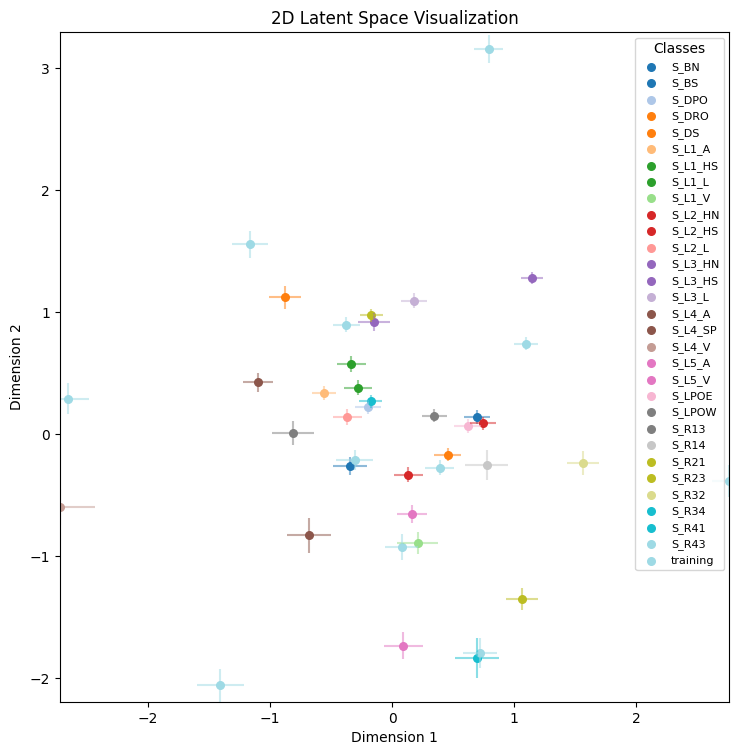

In [33]:
plot_2d_latent_space(full_centroid_means, families_discarded_train, latent_stdevs=full_centroid_stdevs)

# Generation

In [34]:
generation = np.load(generated_data_path)
generation.shape

(100, 7, 100)

In [35]:
generation_df = pd.read_csv(generation_df_path)
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.112772        0.280486     29.519943             60.0   
1        0.145945        0.292695      0.656991             36.0   
2        0.042965        0.110745      0.112218             80.0   
3        0.113008        0.216220      0.287757             60.0   
4        0.120633        0.168558      0.239532             36.0   

   correct_order  inversions  kendall_tau_distance  nearest_orbit  \
0           80.0        33.0              0.013333          34390   
1           87.0        21.0              0.008485          18137   
2           81.0        45.0              0.018182          12946   
3           81.0        41.0              0.016566          24150   
4           90.0        22.0              0.008889          35454   

   nearest_orbit_distance  
0                5.702001  
1                2.196635  
2                1.376137  
3                2.905468  
4                1.737605

In [36]:
refined_orbits = np.load(refined_data_path)
reordered_refined_orbits, _, _ = reorder_orbits(refined_orbits)
refined_orbits.shape

(142, 7, 100)

In [37]:
refined_orbits_df = pd.read_csv(refined_orbits_df_path)
refined_orbits_df.head()

id  old_period     period  iterations_convergence         error  \
0   0    6.185466   6.276237                      16  2.757237e-10   
1   2    4.824748   4.421330                      10  1.183523e-11   
2   3    6.209363   6.260455                      10  8.816831e-12   
3   4   11.320227  11.320299                       9  8.994090e-13   
4   6    5.257554   5.508234                       7  3.173709e-10   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0        0.177585       -0.036163       -0.017091       -0.022055   
1        1.034793        0.026559        0.024956       -0.049169   
2        0.269258       -0.126835        0.733265       -0.240504   
3        0.829688        0.067805        0.025322        0.310614   
4        1.025631        0.039103        0.057501        0.084158   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        6.131807       -0.014057      0.169831     -0.080776 -2.012895e-19   
1       -0.345286        0.455558      1.113329      0.026832 -5.444526e-02   
2       -1.266169       -0.157913      0.274205      0.174975  9.392958e-01   
3        0.605984        0.012557      0.903320      0.144770  4.299740e-02   
4       -0.266062        0.396420      1.097873     -0.026970  5.131826e-02   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0      0.566086      2.739699  9.573277e-19            156.0           76.0   
1      0.094260     -0.187235  3.951087e-01            122.0           75.0   
2      0.350699     -1.252080  1.291137e-01             60.0           78.0   
3      0.306578      0.462901 -6.464936e-02             20.0           93.0   
4     -0.103339     -0.278440  5.407959e-01             54.0           85.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        96.0              0.038788               4.357608e-12   
1        77.0              0.031111               1.204380e-12   
2        37.0              0.014949               1.211275e-12   
3        12.0              0.004848               1.926536e-12   
4        30.0              0.012121               3.504851e-12   

   propagated_velocity_error  propagated_energy_error  \
0               8.359655e-12             6.719029e-12   
1               3.008974e-12             2.259939e-12   
2               3.295515e-12             1.714326e-12   
3               2.950931e-12             4.853132e-14   
4               1.403516e-11             1.008237e-10   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.299591           2.173549   
1                       0.026008           2.979393   
2                       0.564629           0.411586   
3                       0.338986           2.806261   
4                       0.056046           2.810241   

   period_distance_with_generation  feature_closest_orbit  \
0                         0.090771                  34557   
1                         0.403418                  12882   
2                         0.051091                  24144   
3                         0.000072                     56   
4                         0.250681                  19091   

   feature_distance_from_closest_orbit  nearest_orbit  nearest_orbit_distance  \
0                             0.000012          34674                3.770017   
1                             0.000010          12925                0.928670   
2                             0.001589          24150                2.474596   
3                             0.005426          35467                2.293499   
4                             0.002178          19093                0.803715   

   distance_from_generation  centroid_distance  feature_centroid_distance  \
0                  6.249074           1.220051                   1.003881   
1                  1.438901           0.840641                   2.889847   
2                  3.385928           2.692387               

In [38]:
index_100 = refined_orbits_df[refined_orbits_df['id'] >= 100].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 100].empty else None
index_200 = refined_orbits_df[refined_orbits_df['id'] >= 200].index[0] if not refined_orbits_df[refined_orbits_df['id'] >= 200].empty else None

In [39]:
sample1_orbits = reordered_refined_orbits[:index_100,1:,:]
sample1_orbits.shape

(45, 6, 100)

In [40]:
sample2_orbits = reordered_refined_orbits[index_100:index_200,1:,:]
sample2_orbits.shape

(30, 6, 100)

In [41]:
sample3_orbits = reordered_refined_orbits[index_200:,1:,:]
sample3_orbits.shape

(67, 6, 100)

In [42]:
orbits_paths1 = ['../experiments/experiment_116/images/exp116_generated_orbits_sample1.png',
                '../experiments/experiment_116/images/exp116_refined_orbits_sample1.png',
                '../experiments/experiment_116/images/exp116_generated_orbits_sample2.png',
                '../experiments/experiment_116/images/exp116_refined_orbits_sample2.png',
                '../experiments/experiment_116/images/exp116_generated_orbits_sample3.png',
                '../experiments/experiment_116/images/exp116_refined_orbits_sample3.png',]

label_images1 = ['Random Sample Generation (n=100)', 'Random Sample Refinement (n=45)',
                'Grid Sample Generation (n=100)', 'Grid Sample Refinement (n=30)',
                'Discarded Centroid Sample Generation (n=100)', 'Discarded Centroid Sample Refinement (n=67)']

In [43]:
orbits_paths = ['../experiments/experiment_116/images/exp116_generated_orbits_that_converged.png',
                '../experiments/experiment_116/images/exp116_refined_orbits.png']

label_images = ['Generated Orbits that Converged', 'All Converged Orbits']

In [44]:
results = np.array([jacobi_constant(np.transpose(full_data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
full_orbit_df['calculated_jacobi'] = results

features_used = ['period', 'calculated_jacobi']

dataset_features = full_orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values 

In [45]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()[:index_100]
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(45, 7, 100)

## Visualization

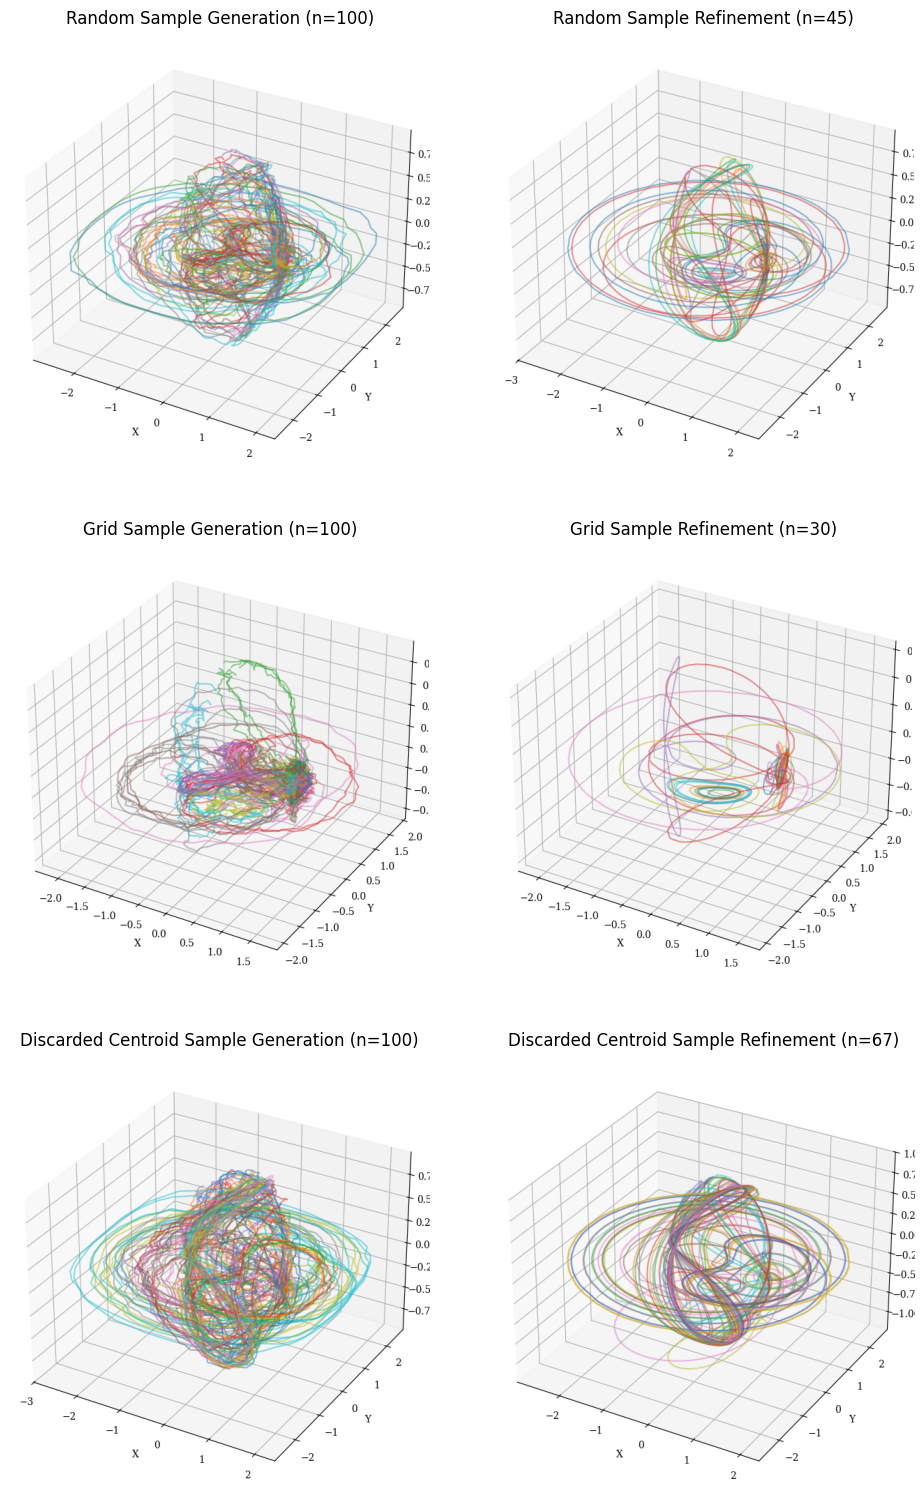

In [ ]:
create_image_grid_from_routes(orbits_paths1, crop_length=23, hspace=0.2, label_images=label_images1)

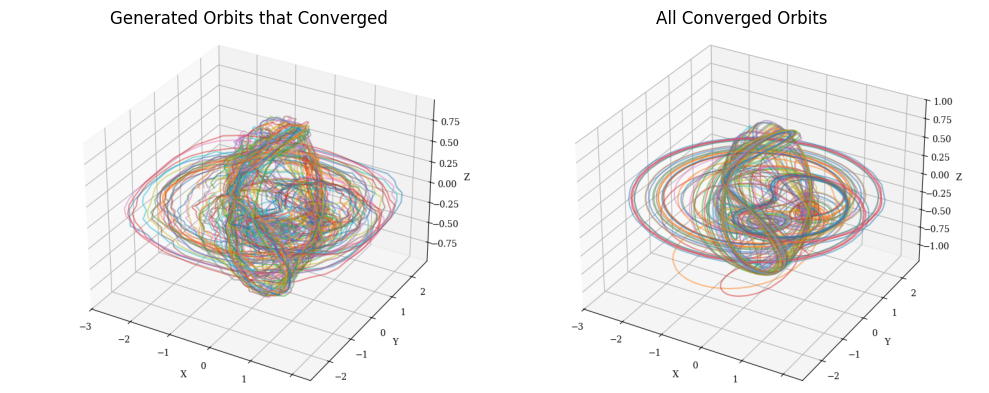

In [ ]:
create_image_grid_from_routes(orbits_paths, crop_length=123, hspace=0.2, label_images=label_images, grid_size=(1,2))

## Latent Space

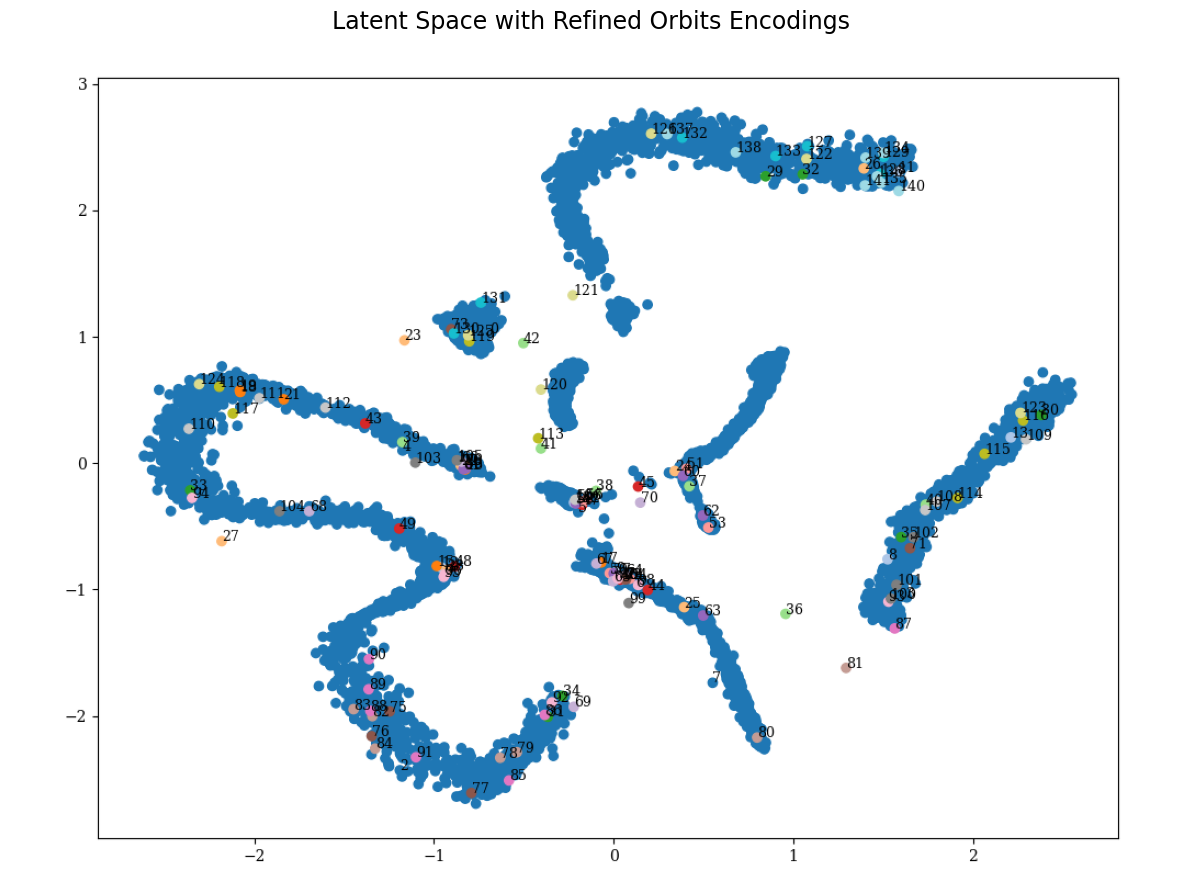

In [ ]:
ls_path = '../experiments/experiment_116/images/exp116_combined_latent_space.png'
plot_single_image(ls_path, crop_length=70, title='Latent Space with Refined Orbits Encodings')

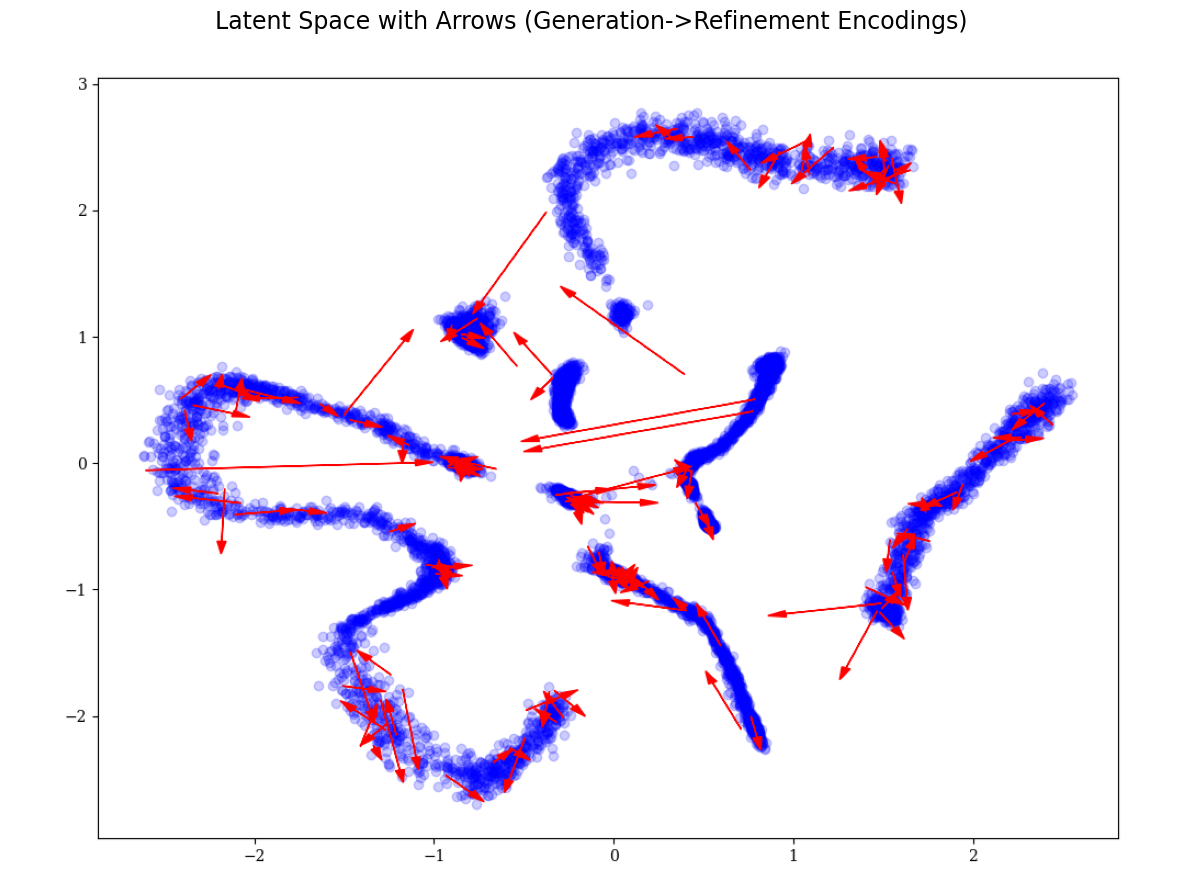

In [ ]:
ls_arrows_path = '../experiments/experiment_116/images/exp116_combined_latent_space_arrows.png'
plot_single_image(ls_arrows_path, crop_length=70, title='Latent Space with Arrows (Generation->Refinement Encodings)')

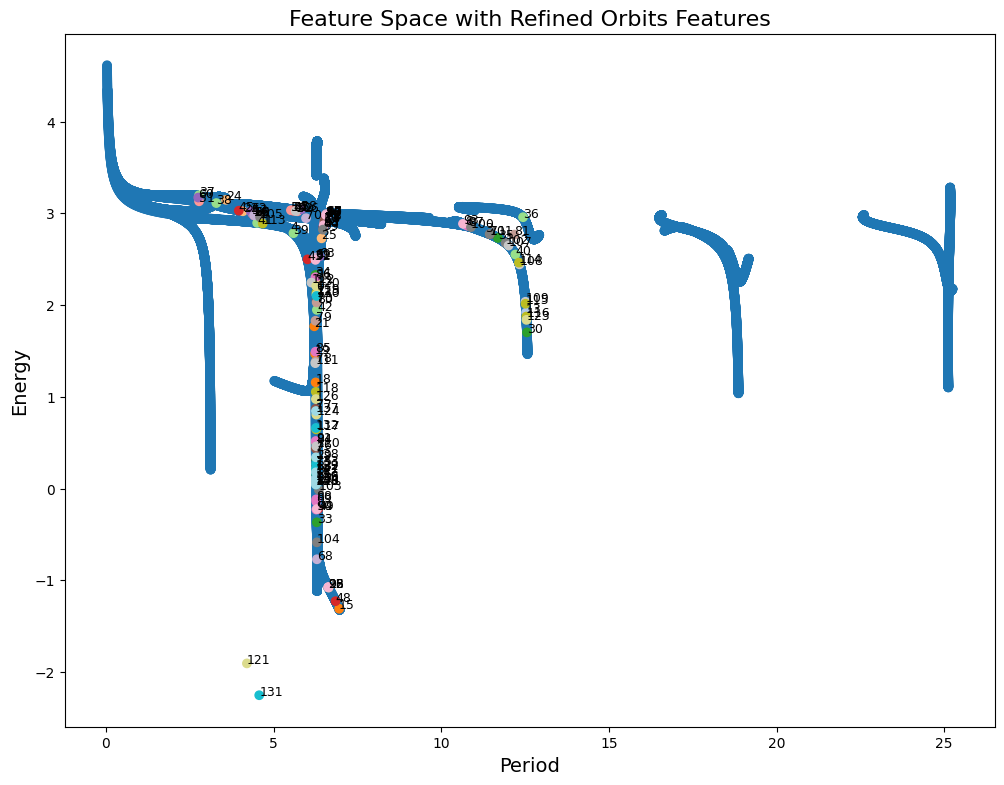

In [50]:
plot_combined_2d_latent_space(dataset_features, refined_orbits_features, title= 'Feature Space with Refined Orbits Features',
                              synthetic_labels=list(range(0, len(refined_orbits_df))),
                              annotation_mode='numbers', axis_labels=('Period', 'Energy'))

# Regression

In [51]:
latent_means.shape

(11367, 2)

In [52]:
latent_stdevs.shape

(11367, 2)

In [53]:
features.shape

(11367, 3)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

def plot_linear_regression(latent_means, features, feature_names, normalize=True):
    """
    Perform linear regression for each feature, visualize the results, and return regression metrics.
    
    Parameters:
    - latent_means: np.ndarray of shape (n_samples, latent_dim
    ), the latent space coordinates.
    - features: np.ndarray of shape (n_samples, n_features), the feature values.
    - feature_names: List of strings representing the names of the features.
    - normalize: Boolean, whether to normalize the features and latent space (default: False).

    Returns:
    - results: Dictionary containing coefficients, intercepts, and R² values for each feature.
    """
    num_features = features.shape[1]
    fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
    
    # Handle single feature case for consistent indexing
    if num_features == 1:
        axes = [axes]
    
    results = {}
    
    # Normalize data if requested
    if normalize:
        scaler_latent = StandardScaler()
        latent_means_normalized = scaler_latent.fit_transform(latent_means)
        scaler_features = StandardScaler()
        features_normalized = scaler_features.fit_transform(features)
    else:
        latent_means_normalized = latent_means
        features_normalized = features
    
    for i, feature_name in enumerate(feature_names):
        target_feature_values = features_normalized[:, i]
        
        # Perform linear regression
        model = LinearRegression()
        model.fit(latent_means_normalized, target_feature_values)
        coefficients = model.coef_
        intercept = model.intercept_
        predictions = model.predict(latent_means_normalized)
        r_squared = r2_score(target_feature_values, predictions)
        
        # Store results
        results[feature_name] = {
            'coefficients': coefficients,
            'intercept': intercept,
            'r_squared': r_squared
        }
        
        # Plot latent space with color-coded feature values
        scatter = axes[i].scatter(latent_means_normalized[:, 0], latent_means_normalized[:, 1], 
                                   c=target_feature_values, cmap='viridis', alpha=0.5)
        axes[i].set_title(f'{feature_name} (R² = {r_squared:.4f})')
        axes[i].set_xlabel('Latent Dimension 1')
        axes[i].set_ylabel('Latent Dimension 2')
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i])
        
        # Plot regression direction (line)#
        x_vals = np.array(axes[i].get_xlim())
        y_vals = coefficients[0] * x_vals + intercept
        axes[i].plot(x_vals, y_vals, '--r', label='Regression Line')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

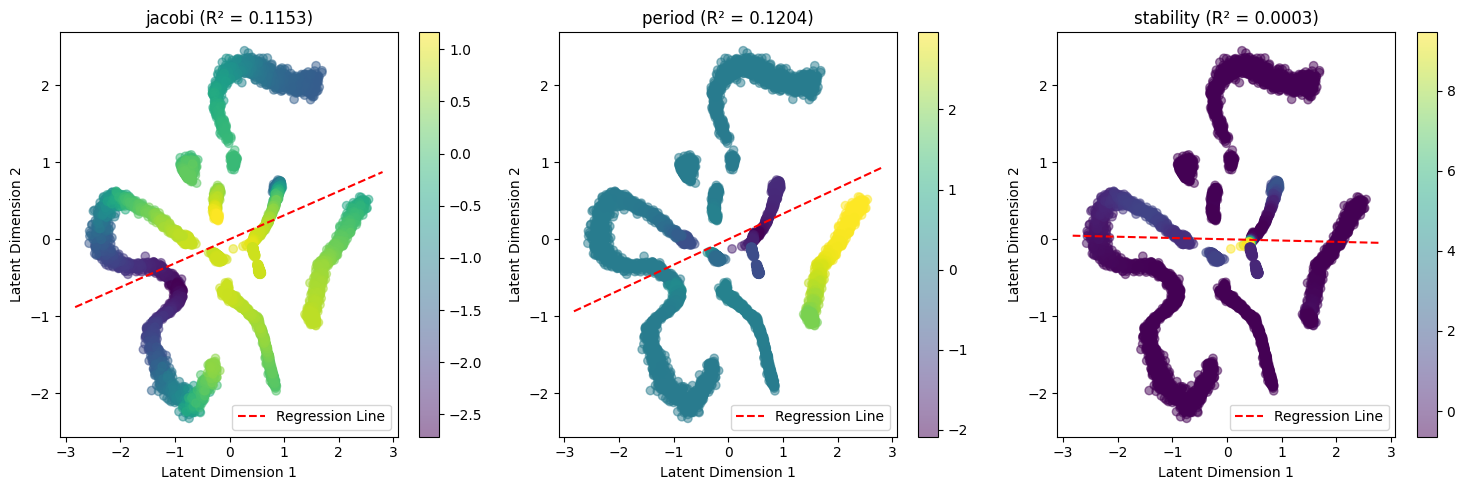

{'jacobi': {'coefficients': array([ 0.31158406, -0.1505835 ], dtype=float32), 'intercept': np.float32(7.764073e-08), 'r_squared': 0.11529405008124183}, 'period': {'coefficients': array([ 0.3308046 , -0.12141843], dtype=float32), 'intercept': np.float32(5.659336e-08), 'r_squared': 0.12035102886105653}, 'stability': {'coefficients': array([-0.01649997,  0.0047327 ], dtype=float32), 'intercept': np.float32(-1.3064979e-08), 'r_squared': 0.0002872142782130993}}


In [55]:
results = plot_linear_regression(latent_means, features, feature_names)
print(results)

# Discovery

In [56]:
s1_refined_orbits = refined_orbits_df.iloc[:index_100]
s1_refined_orbits.shape

(45, 43)

In [57]:
filter_condition = s1_refined_orbits[['family_of_feature_closest_orbit', 'family_of_closest_orbit']].isin(discarded_family_ids).any(axis=1)
discovery_df = s1_refined_orbits[filter_condition]
discovery_df.shape

(11, 43)

In [58]:
discovery_df.head()

id  old_period     period  iterations_convergence         error  \
3    4   11.320227  11.320299                       9  8.994090e-13   
5    7    5.872201   6.793303                      12  9.607116e-13   
17  38    6.584646   6.574390                       8  7.481972e-10   
22  48    4.525820   4.084648                       8  7.850147e-10   
24  51    6.378485   3.580047                      18  9.001414e-13   

    initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
3         0.829688        0.067805        0.025322        0.310614   
5         1.181000        0.021286        0.175626        0.028626   
17        0.548686       -0.678132        0.009372       -0.253947   
22        0.955600        0.066224        0.036040        0.098453   
24        1.100201        0.043669        0.168450        0.056379   

    initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
3         0.605984        0.012557      0.903320      0.144770  4.299740e-02   
5        -0.260612        0.127594      1.189627     -0.004713  7.103575e-16   
17       -0.010911        0.031595      0.549798     -0.958510 -3.196921e-10   
22        0.235922        0.284561      1.092872     -0.032781  1.108721e-01   
24       -0.267246        0.128609      1.130908     -0.004831  9.638051e-02   

    final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
3       0.306578      0.462901 -6.464936e-02             20.0           93.0   
5      -0.007498     -0.506995  6.543769e-16            122.0           74.0   
17     -0.174320     -0.118334  7.328526e-10            250.0           79.0   
22     -0.136312     -0.062179  3.093468e-01            146.0           72.0   
24     -0.023650      0.014561  7.495071e-02           1580.0           75.0   

    inversions  kendall_tau_distance  propagated_position_error  \
3         12.0              0.004848               1.926536e-12   
5         72.0              0.029091               1.733104e-12   
17       168.0              0.067879               5.194944e-11   
22        88.0              0.035556               9.190815e-12   
24       917.0              0.370505               1.053132e-12   

    propagated_velocity_error  propagated_energy_error  \
3                2.950931e-12             4.853132e-14   
5                4.036969e-12             7.575085e-14   
17               9.722150e-11             1.046360e-10   
22               3.905901e-11             7.200532e-11   
24               1.791344e-12             1.093177e-14   

    latent_distance_to_generation  calculated_jacobi  \
3                        0.338986           2.806261   
5                        0.117600           2.934508   
17                       0.085135           2.989849   
22                       0.054746           3.023106   
24                       0.602581           3.147719   

    period_distance_with_generation  feature_closest_orbit  \
3                          0.000072                     56   
5                          0.921102                  17432   
17                         0.010256                  26709   
22                         0.441172                  11346   
24                         2.798438                  31005   

    feature_distance_from_closest_orbit  nearest_orbit  \
3                              0.005426          35467   
5                              0.003388           3039   
17                             0.000024          29925   
22                             0.002748          12872   
24                             0.028252          18053   

    nearest_orbit_distance  distance_from_generation  centroid_distance  \
3                 2.293499                  2.554175           1.972114   
5                 3.920080                  4.060031           0.422964   
17                1.583756                  2.151194           0.787559   
22                1.056198                  1.749296           0.822774   
24      

In [59]:
discovery_df['nearest_orbit_distance'].iloc[0].round(2)

np.float64(2.29)

In [60]:
refinement_indexes = discovery_df.index.to_list()
feature_closest_orbit_indexes = discovery_df['feature_closest_orbit'].to_list()
nearest_orbit_indexes = discovery_df['nearest_orbit'].to_list()

discovery_refinement = reordered_refined_orbits[refinement_indexes]
feature_closest_orbits = full_data[feature_closest_orbit_indexes]
nearest_orbits = full_data[nearest_orbit_indexes]

In [61]:
refinement_and_closers = np.stack(
    (discovery_refinement, feature_closest_orbits, nearest_orbits),
    axis=1
)
refinement_and_closers.shape

(11, 3, 7, 100)

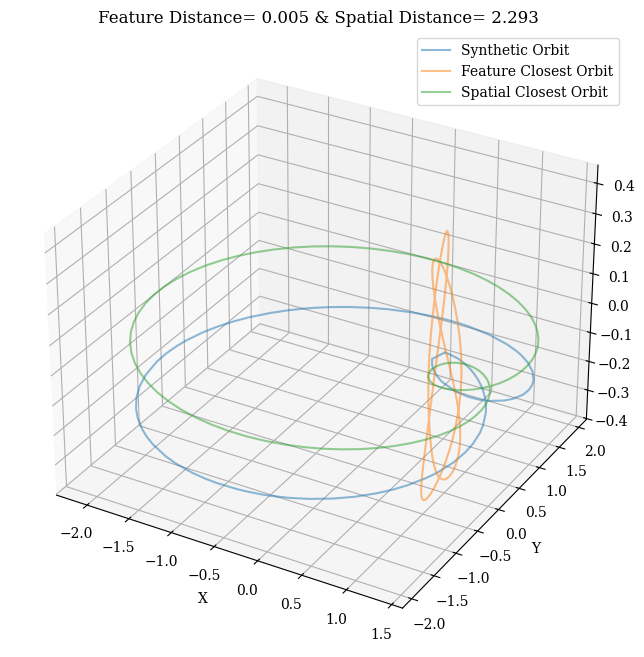

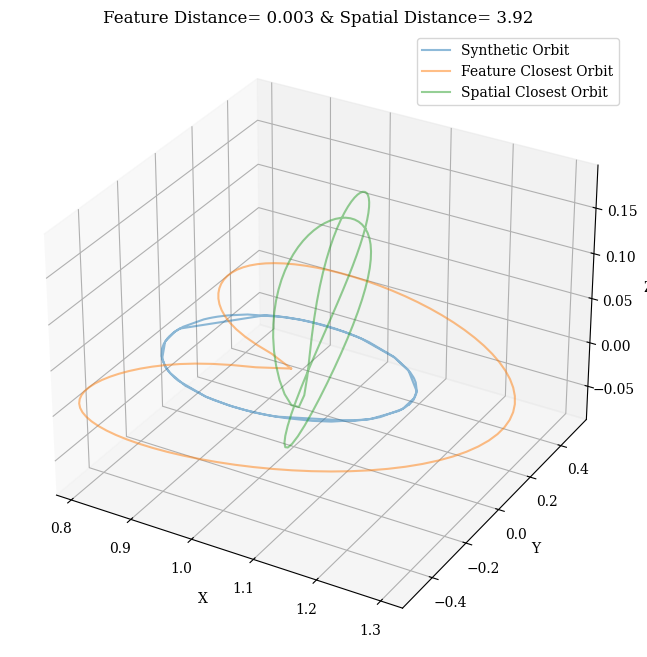

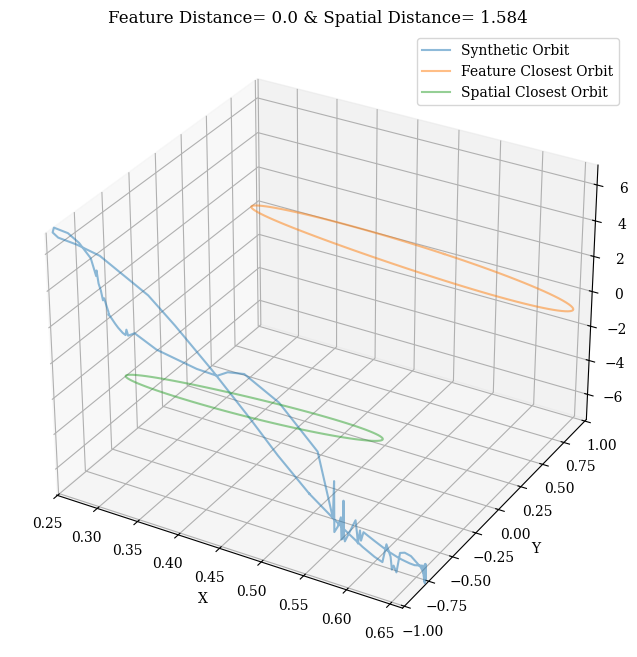

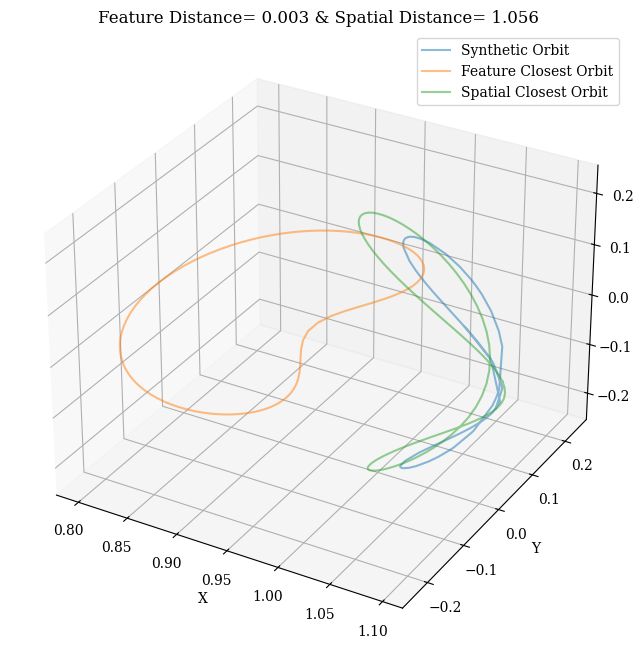

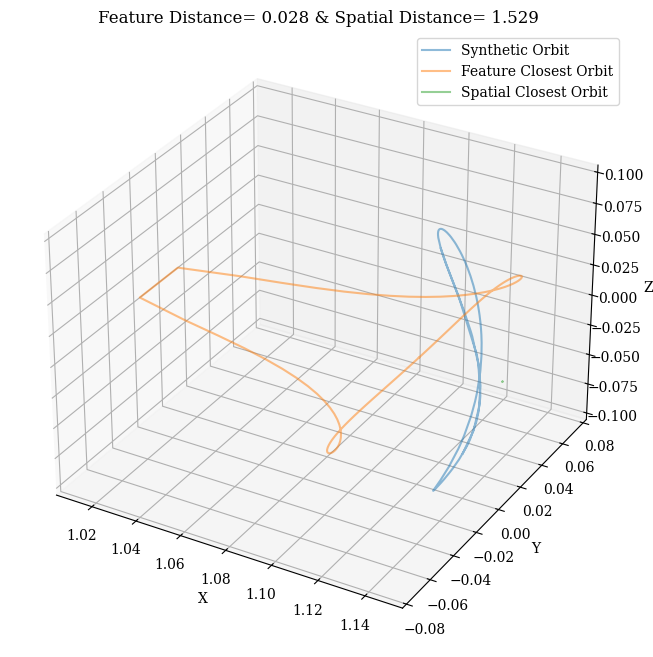

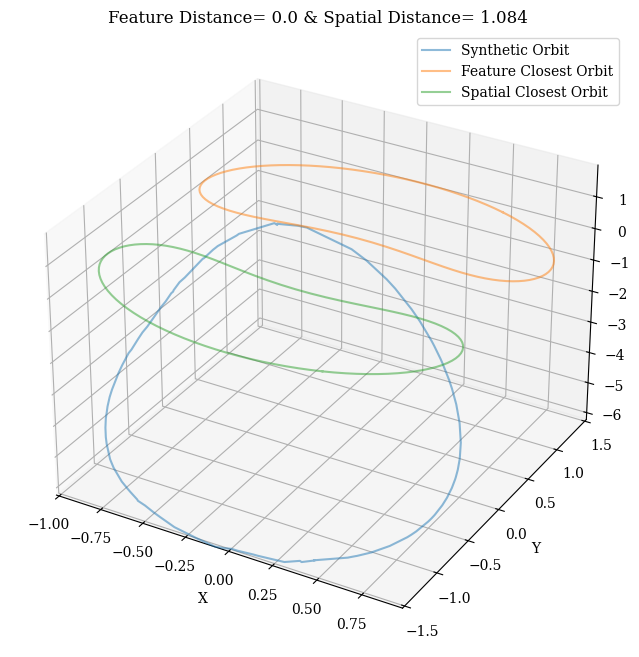

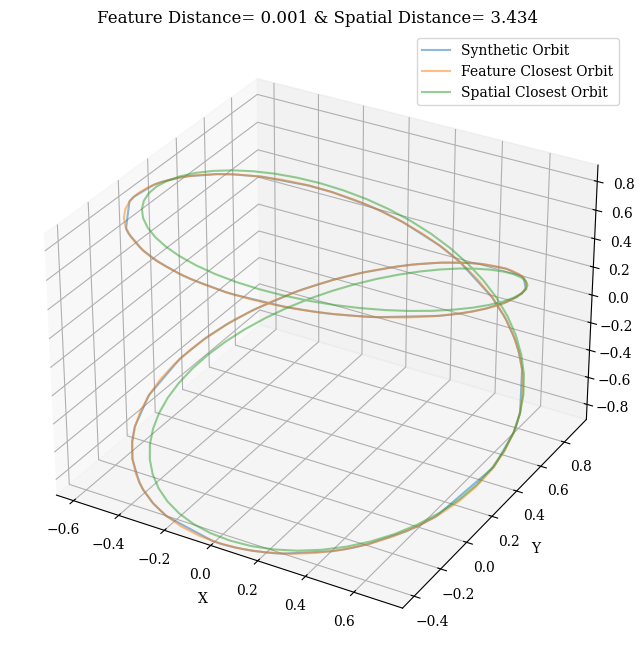

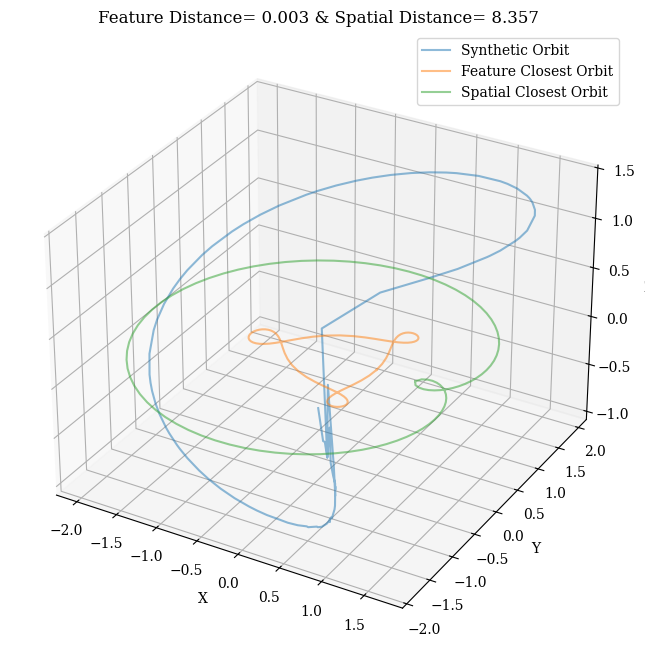

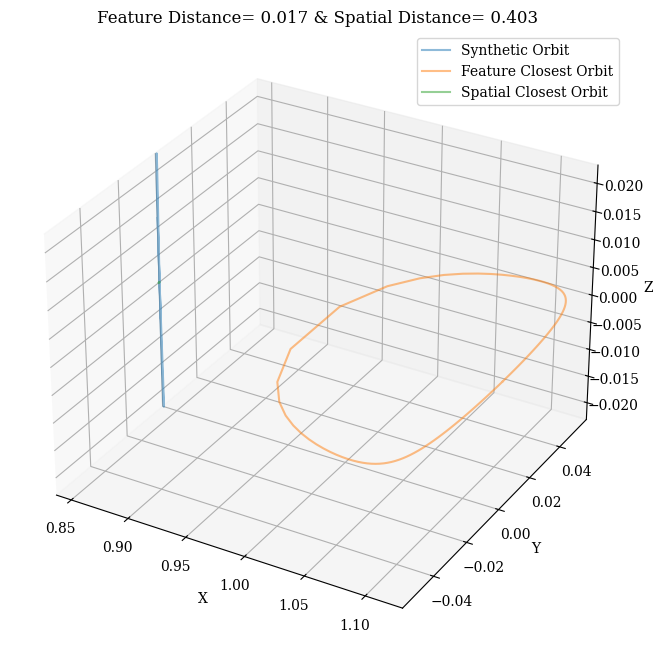

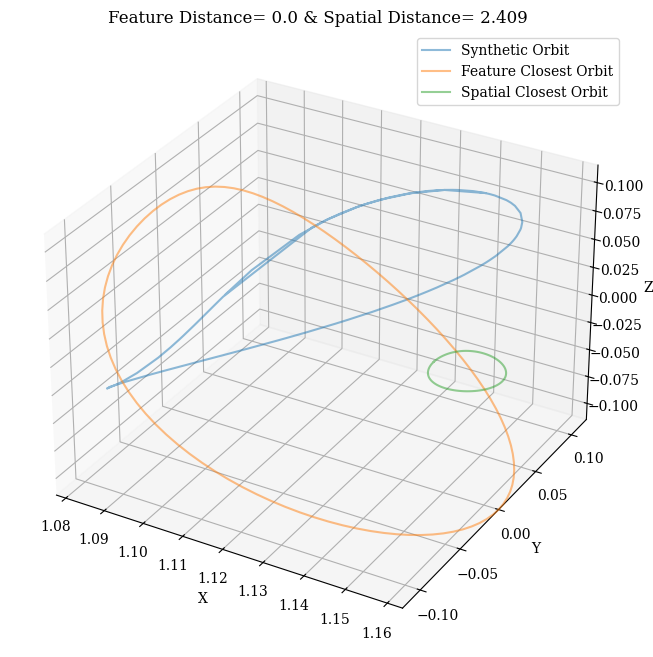

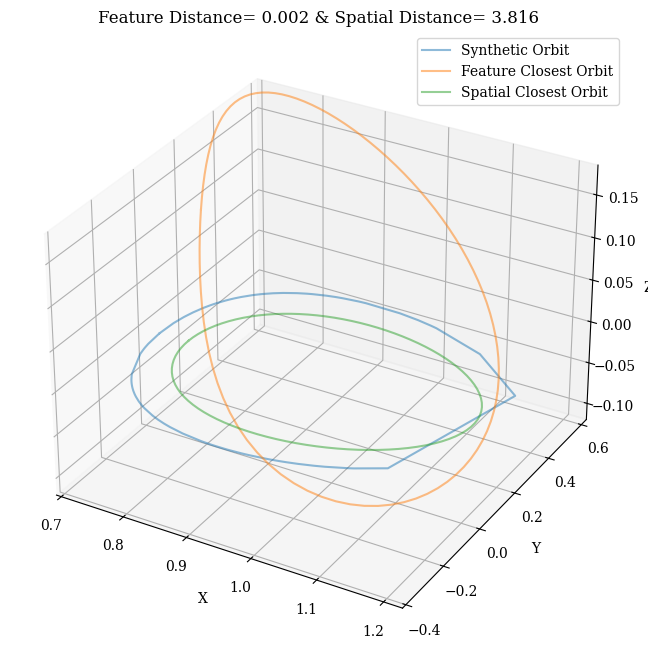

In [62]:
for i in range(len(refinement_and_closers)):
    title = f"Feature Distance= {discovery_df['feature_distance_from_closest_orbit'].iloc[i].round(3)} & Spatial Distance= {discovery_df['nearest_orbit_distance'].iloc[i].round(3)}"
    visualize_static_orbits(refinement_and_closers[i,:,1:,:], title=title,
                            orbit_names=['Synthetic Orbit', 'Feature Closest Orbit', 'Spatial Closest Orbit'])